In [2]:
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import NaN
from functions import * # import functions from the .py file

from pylab import rcParams
rcParams["figure.figsize"] = 16, 4

PAYLOADSIZE = 44

if PAYLOADSIZE % 2 != 0:
    print("Alarm! the payload size is not even.")
NUM_16RND = (PAYLOADSIZE-2)//2 # how many 16 bits random number included in each frame
MAX_SEQ = 256 # (decimal) maximum seq number defined by the length of the seq, the length of seq is 1B

## Log file

**For a fair comparison between groups, must follow the output format below**
<br>$\color{red}{\text{timestamp\_rx }| \text{ len [hex] } \text{ seq [hex] } \text{ payload [hex] }| \text{rssi} }$
<br>$\text{ len [hex]}$ = payload length + 1 (seq. field length [1B])
<br>$\text{ payload [hex]}$ should start with the pseudo sequence number [2B], indicates the starting byte's position in the file.
***
*Example log file output for one frame with reciever timestamp xxxx, frame length, seq number and random payload, received signal strength.*
<br>15:17:18.394 |0f 46 bd f8 f7 ea 41 ac 1b be 05 a0 7f d2 09 d4 |  -91 CRC error
<br>$\color{red}{\text{delimiter for four variables is "|" and delimiter for the payload each byte is the space " ".}}$

In [3]:
# define the file name
filename = "test1"
# import file to jupyter notebook
df = readfile("./" + filename + ".txt")
# check the imported data first 10 lines
df.head(10)
print(len(df.payload[2]))

131


In [4]:
# delete packets of invalid length (aka. error in length field at variable receiver length config) (PAYLOADSIZE + 2B pesudo sequence number)
test_bad = df[df.payload.apply(lambda x: len(x)==((PAYLOADSIZE)*3-1))]
#test_bad = df[df.payload.apply(lambda x: len(x)==131)]
test_bad.reset_index(inplace=True)


In [5]:
err = 0
def majority_vote_sample(tokens):
    """
    Takes a 6-byte sequence representing three copies of a 16-bit sample
    and returns the majority vote sample (as a 16-bit integer).
    """
    if len(tokens) != 6:
        raise ValueError("Each sample must be 6 bytes long.")
    
    # Extract the three copies
    sample1 = "".join(tokens[0:1])
    sample2 = "".join(tokens[2:3])
    sample3 = "".join(tokens[4:5])
    
    # Check for majority: if at least two match, that's our vote.
    if (sample1 == sample2) or (sample1 == sample3):
        return sample1
    elif (sample2 == sample3):
        return sample2
    else:
        # No majority found: optionally, you might choose to flag this sample.
        # For now, we'll simply return sample1 (or raise an error)
        print("Warning: No majority found for sample bytes", tokens)
        return sample1  # or return None / raise an exception

# Example: processing a full payload
def process_payload(buffer, header_length=2):
    """
    Processes a buffer containing an optional header followed by
    repeated samples. Returns a list of corrected 16-bit samples.
    """
    tokens = buffer.split()
    corrected_samples = []
    # Start of data payload after header (if any)
    for i in range(header_length, len(tokens), 6):
        sample_tokens = tokens[i:i+6]
        if len(sample_tokens) < 6:
            break  # Avoid incomplete sample at end of buffer
        corrected_sample = majority_vote_sample(sample_tokens)
        corrected_samples.append(corrected_sample)
    return " ".join(corrected_samples)

test = test_bad.copy()
test["payload"] = test_bad["payload"].apply(process_payload)
print(test.head(10))

    

   level_0  index                 time_rx  rssi  seq               payload
0        0      0 2025-04-08 00:00:05.288   -56    0  13 1f 1b 25 21 0f 20
1        1      1 2025-04-08 00:00:05.558   -57    1  2b 24 26 1a 22 14 1f
2        2      2 2025-04-08 00:00:05.828   -56    2  25 1a 23 23 19 17 25
3        3      3 2025-04-08 00:00:06.097   -56    3  1f 27 31 1c 23 17 22
4        4      4 2025-04-08 00:00:06.367   -56    4  1c 25 20 1c 1e 17 1a
5        5      5 2025-04-08 00:00:06.637   -58    5  27 2a 2b 1e 1a 22 19
6        6      6 2025-04-08 00:00:06.906   -56    6  25 2f 25 22 1e 20 16
7        7      7 2025-04-08 00:00:07.176   -56    7  12 22 2c 11 1f 12 22
8        8      8 2025-04-08 00:00:07.446   -56    8  29 31 26 1e 20 2b 19
9        9      9 2025-04-08 00:00:07.715   -58    9  20 19 0e 23 12 23 14


# Time

## Definition

**Evaluation metric**
<br>*File Transmission Time: the total latency that certain amount of Data $F$ is delivered to the destination.*
<br> $File\ Delay = Rx\_timestamp[N] - Rx\_timestamp[0]$
<br> where $N$ is the last packet
***
**Interesting to look at**:
<br>*Timestamp difference*: $\Delta T[i] = Rx\_timestamp[i] - Tx\_timestamp[i]$
1. *Worst-case packet delay*: the delay of the packet that takes the longest time to traverse.
2. *Packet delay variation*: the std of the packet delay.

In [6]:
# compute the file delay
file_delay = df.time_rx[len(df) - 1] - df.time_rx[0]
# convert the timedelta to s
file_delay_s = np.timedelta64(file_delay, "ms").astype(int) / 1000
print(f"The time it takes to transfer the file is : {file_delay}, which is {file_delay_s} seconds.")

The time it takes to transfer the file is : 0 days 00:00:58.512000, which is 58.512 seconds.


# Reliability

## Definition

**Evaluation metric**
<br>*Quality of data transfer.*
<br>*Bit Reliability*: The ratio of data bits correctly delivered to the data sink.
<br>*Bit Error Rate*: The ratio of data bits incorrectly delivered to the data sink.
$$Bit\ Reliability = 1 - BER = 1 - \frac{Number\ of\ wrong\ bit}{Total\ Number\ of\ bit\ received}$$
<br>*Achieved Data Rate*: The bit error rate is calculated based on the received data only. Missing packets do not affect the bit error rate, but are reflected in the achievable data rate.

## Statistics

In [7]:
# compute the BER for all received packets
# return the in total ber for received file, error statistics and correct file content supposed to be transmitted
ber = compute_ber(test, PACKET_LEN=NUM_16RND*2)
bit_reliability = (1-ber)*100
print(f"Bit error rate [%]: {(ber*100):.8f}\t\t(in received packets within pseudo sequence + payload) ")
if len(df) < 1:
    print("Data rate [bit/s]: More than one packet required for analysis.")
else:
    print(f"Data rate [bit/s]: {(len(df)*NUM_16RND*2/file_delay_s):.8f}\t\t(directly impacted by missed packets) ")

The total number of packets transmitted by the tag is 218.
Bit error rate [%]: 30.38171691		(in received packets within pseudo sequence + payload) 
Data rate [bit/s]: 156.48072190		(directly impacted by missed packets) 


Note: if individual packets have a high bit-error rate, it could be that the pseudo-sequence number was corrupted and the script could not identify the expected payload correctly.


Text(0.5, 0, 'Seq. Number')

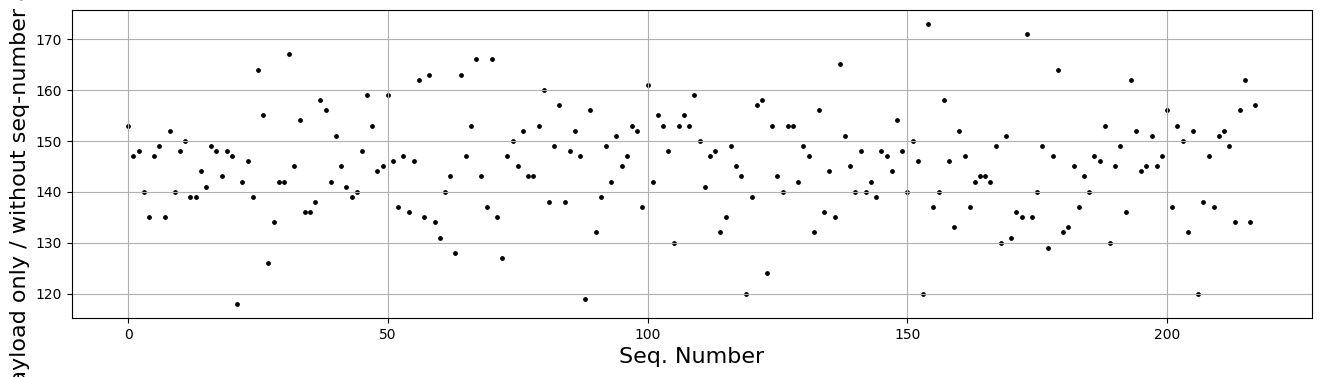

In [8]:
# BER for each packet
print("Note: if individual packets have a high bit-error rate, it could be that the pseudo-sequence number was corrupted and the script could not identify the expected payload correctly.")
plt.scatter(range(len(df)), [compute_ber_packet(row,PACKET_LEN=NUM_16RND*2)[0] for (_,row) in df.iterrows()], marker='o', s=6, color='black')
plt.grid()
plt.ylabel('Bit Error Rate [%] (payload only / without seq-number and pseudo-seq-number)', fontsize=16)
plt.xlabel('Seq. Number', fontsize=16)

# Distance

## Definition

**The communication distance of the system.**
<br>$D_{1}$: the distance between carrier<->backscatter_tag[m]
<br>$D_{2}$: the distance between backscatter_tag<->receiver[m]
<br> Distance metric = $D_{1}^2D_{2}^2$
<br>

In [9]:
# record the distance
dis_carrier_tag = 1
dis_tag_rx = 4

dis_metric = dis_carrier_tag**2*dis_tag_rx**2
print(f"Distance metric is: {dis_metric}")

Distance metric is: 16


# Radarplot

**Please pay attention to the unit**
<br> <font color='red'>Time</font>: use second as unit
<br> <font color='red'>Reliability</font>: use the percent as unit
<br> <font color='red'>Distance</font>: use meter as unit
<br>**Metics = [Time(s), Reliability(%), Distance(m)]**
<br> <font color='red'>Always keep the reference in your plot.</font>
<br> Tips: for ploting, time metric uses $\frac{1}{Time}*1000$ as the time metric, the higher the value the better the system performance

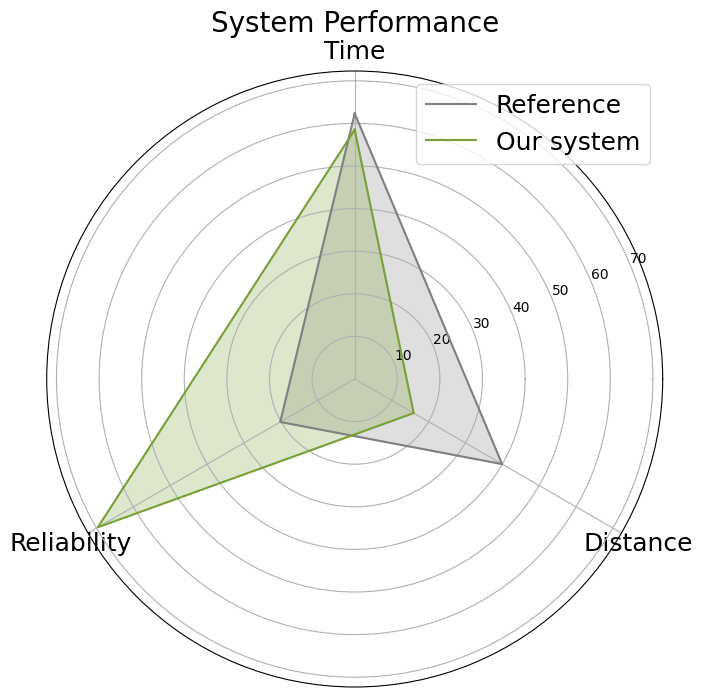

In [10]:
metrics = [file_delay_s, bit_reliability, dis_metric]
radar_plot(metrics)